# CO2 modelling
This example highlights two aspects of GAM modelling:

- Using cyclical smooths for seasonal components
- The dangers of extrapolation

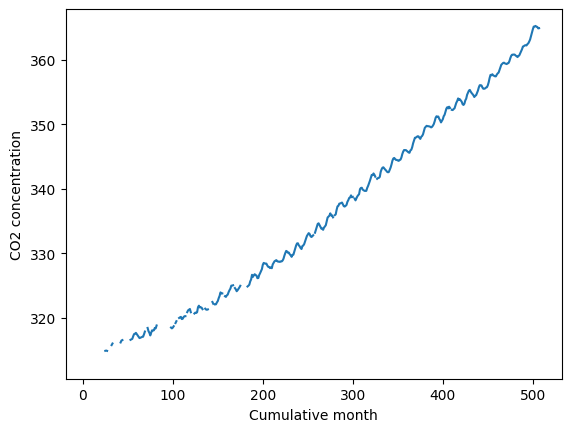

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pymgcv.basis_functions import CubicSpline
from pymgcv.gam import GAM, AbstractGAM
from pymgcv.terms import S
from pymgcv.utils import load_rdata_dataframe_from_url

data = load_rdata_dataframe_from_url(
    "https://github.com/cran/gamair/raw/master/data/co2s.rda",
)

plt.plot(data["c.month"], data["co2"])
plt.xlabel("Cumulative month")
plt.ylabel(r"CO2 concentration")
plt.show()


We'll consider two models, one simple cubic spline model, and one where we use a cyclical component for the month of the year in addition to an overall time component:

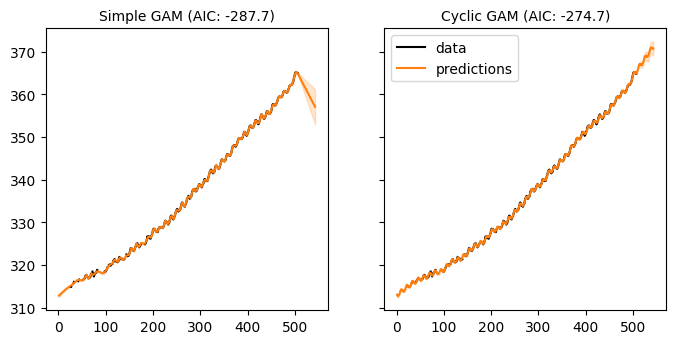

In [2]:
simple_gam = GAM({"co2": S("c.month", bs=CubicSpline(), k=100)})
simple_gam.fit(data)

cyclic_gam = GAM(
    {
        "co2": S("c.month", bs=CubicSpline(), k=50)
        + S("month", bs=CubicSpline(cyclic=True), k=12),
    },
)
cyclic_gam.fit(data, knots={"month": np.arange(1, 13)})

def fit_and_plot_prediction(gam: AbstractGAM, data, predict_data, ax):
    gam.fit(data)
    predictions = gam.predict(data=predict_data, compute_se=True)
    ax.plot(data["c.month"], data["co2"], label="data", color="black")
    ax.plot(
        predict_data["c.month"],
        predictions["co2"].fit,
        label="predictions",
        color="tab:orange",
    )
    ax.fill_between(
        predict_data["c.month"],
        predictions["co2"].fit - 2 * predictions["co2"].se,
        predictions["co2"].fit + 2 * predictions["co2"].se,
        alpha=0.2,
        color="tab:orange",
    )


predict_data = {
    "c.month": np.arange(1, 544),
    "month": (np.arange(0, 543) % 12) + 1,
}

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)
models = {"Simple GAM": simple_gam, "Cyclic GAM": cyclic_gam}

for ax, (name, gam) in zip(axes, models.items(), strict=True):
    fit_and_plot_prediction(gam, data, predict_data, ax)
    ax.set_title(f"{name} (AIC: {gam.aic():.1f})", fontsize="medium")
    ax.set_box_aspect(1)

plt.legend()
plt.show()

- The simple model without the cyclical component does not extrapolate in any reasonable way!
- The simple model requires a very high ``k`` value to 

The second model visually looks much better, and has a much lower AIC.